# Policy Gradient (PG)



Referências:
- [Schulman, John. _Optimizing Expectations_: From Deep Reinforcement Learning to Stochastic Computation Graphs](https://www2.eecs.berkeley.edu/Pubs/TechRpts/2016/EECS-2016-217.html).
- [Spinning Up](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html)

# Conceito
Em todos os métodos que vimos até agora (Monte Carlo, TD/Q-Learning, ...), o agente aprende uma função de valor $V(s | \theta)$ ou $Q(s,a | \theta)$, onde $\theta$ são os parâmetros/pesos do modelo. O agente então segue uma política ($\varepsilon$-)gulosa, (quase-)deterministica, derivada da função de valor. Esses métodos são todos aproximações de programação dinâmica e encontram a política ótima de maneira indireta.

Um método alternativo é estimar as políticas ótimas diretamente, ou seja, estimar os parâmetros ótimos $\theta$ para a política $\pi(a | s, \theta)$.
Os métodos que utilizam gradientes para realizar essa tarefa são chamados de Policy Gradient.

No caso de DQN, nós estimávamos a qualidade de uma ação usando bootstrap e minizávamos o erro entre o agente e esse $Q_{\mathrm{bootstrap}}$. Em PG, a situação é um pouco diferente, porque não é tão simples estimar diretamente algum "$\pi_{\mathrm{bootstrap}}$". Ao invés disso, utilizamos _gradient ascent_ para maximizar alguma função objetivo, como:

- $J_0(\theta) = V^{\pi_\theta}(s_0)$ (valor do estado inicial)
- $J_{\mathrm{mean}V}(\theta) = E_{s|\theta}\left[V^{\pi_\theta}(s)\right]$ (valor médio)
- $J_{\mathrm{mean}\mathcal{R}}(\theta) = E_{s,a|\theta}\left[\mathcal{R}_s^a\right]$ (recompensa média)
- $J_{\mathrm{mean}G}(\theta) = E_{\tau|\theta}\left[G_\tau\right]$ (retorno médio por episódio)

O algoritmo de PG então se reduz a:
$$\theta_{k+1} = \theta_k + \alpha \nabla_\theta J(\theta_k),$$
onde $\alpha$ é a taxa de aprendizado. Só falta um detalhe bem importante nessa equação: como calcular o gradiente de $J$.

Obs: O resto dessa explicação, assim como a tese de referência, assume que a função objetivo é $J(\theta) = J_{\mathrm{mean}G}(\theta)$, ou seja, queremos maximizar o retorno médio por episódio.


## A probabilidade de uma trajetória

Algo que será bem útil é o cálculo da probabilidade de uma trajetória $\tau = (s_0,a_0,s_1,a_1,\dots)$. Se a distribuição inicial de estados é dada por $\mu(s) = $ _prob. do estado inicial ser_ $s$, temos:
$$p(\tau|\theta) = \mu(s_0) \pi(a_0|s_0,\theta) p(s_1|s_0,a_0) \pi(a_1|s_1,\theta)\cdots.$$
Tomando o log dessa expressão, obtemos:
\begin{align*}
    \log p(\tau|\theta) &= \log \mu(s_0) + \log\pi(a_0|s_0,\theta) + \log p(s_1|s_0,a_0) + \log \pi(a_1|s_1,\theta) + \cdots = \\
                        &= \log \mu(s_0) + \sum_{t=0}^\infty \left[\log \pi(a_t|s_t,\theta) + \log p(s_{t+1} | s_t, a_t)\right]
\end{align*}
Como os únicos termos que dependem de $\theta$ na última expressão são os termos da forma $\log \pi(a_t|s_t,\theta)$, temos por fim:
$$\nabla \log p(\tau|\theta) = \sum_{t=0}^\infty \nabla \log \pi(a_t|s_t,\theta)$$

## O gradiente de $J$

Do cálculo, sabemos que:
$$\frac{d}{dx} \log x = \frac1x \implies \frac{d}{dx} \log g(x) = \frac{1}{g(x)} g'(x).$$
Em cálculo multivariável, vale analogamente:
$$\nabla \log g(\theta) = \frac{1}{g(\theta)} \nabla g(\theta), \quad \text{ou seja}, \quad \nabla g(\theta) = g(\theta) \nabla \log g(\theta).$$

A função objetivo pode ser escrita em forma integral como:
$$J(\theta) = E_{\tau|\theta}\left[G_\tau\right] = \int_\tau p(\tau|\theta) G_\tau d\tau$$

O gradiente de $J$ fica então:
\begin{align*}
    \nabla J(\theta) &= \nabla_\theta \int_\tau p(\tau|\theta) \cdot G_\tau d\tau \\
                     &= \int G_\tau \cdot \nabla_\theta p(\tau|\theta) d\tau \\
                     &= \int G_\tau \cdot p(\tau|\theta) \nabla_\theta \log p(\tau|\theta) d\tau \tag{pois \(\nabla g(\theta) = g(\theta) \nabla \log g(\theta)\)}\\
                     &= \int p(\tau|\theta) \cdot G_\tau \nabla_\theta \log p(\tau|\theta) d\tau \\
                     &= E_{\tau|\theta}\left[G_\tau \nabla_\theta \log p(\tau|\theta)\right] \\
                     &= E_{\tau|\theta}\left[G_\tau \sum_{t=0}^\infty \nabla_\theta \log \pi(a_t|s_t,\theta)\right] \tag{probabilidade da trajetória}
\end{align*}

## Teorema de Policy Gradient

Para qualquer uma das funções objetivo especificadas acima, o gradiente de $J$ é dado por:
$$\nabla_\theta J(\theta) = E_{\tau|\theta}\left[\sum_{t=0}^\infty Q(s_t,a_t|\theta) \nabla_\theta \log\pi(a_t|s_t,\theta)\right].$$

### Demonstração do Teorema de Policy Gradient

A demonstração completa e rigorosa pode ser vista no material de referência e, em particular, [nesse material extra](https://spinningup.openai.com/en/latest/spinningup/extra_pg_proof1.html) do Spinning Up. Aqui será passada apenas a ideia básica. Primeiramente, podemos reescrever o gradiente de $J$ como:
$$\nabla_\theta J(\theta) = E_{\tau|\theta}\left[\sum_{t=0}^\infty G_\tau \nabla_\theta \log \pi(a_t|s_t,\theta)\right].$$
Note que para qualquer instante $t=t_i$, essa fórmula considera o retorno total a partir do instante $t=0$, o que é um pouco contra-intuitivo. Final, o agente deveria considerar apenas as recompensas futuras ($t \ge t_i$) ao decidir qual ação tomar. Essa intuição pode ser confirmada matemáticamente, de forma que:
\begin{align*}
    \nabla_\theta J(\theta) &= E_{\tau|\theta}\left[\sum_{t=0}^T G_{\tau}^{t:\infty} \nabla_\theta \log \pi(a_t|s_t,\theta)\right] \\
                            &= E_{\tau|\theta}\left[\sum_{t=0}^T Q(s_t,a_t|\theta) \nabla_\theta \log \pi(a_t|s_t,\theta)\right]
\end{align*}

Note que assumimos que o episódio tem uma duração máxima $T$ e que a distribuição de estados é estacionária (i.e. $s_t,a_t$ tem a mesma distribuição que $a,t$).

## REINFORCE

O algoritmo mais simples de PG é:

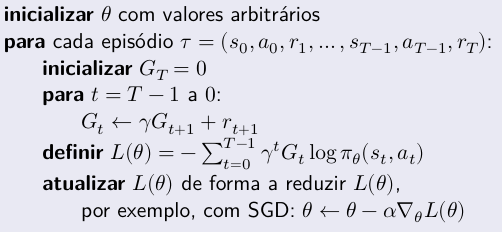


Note que esse algoritmo é on-policy, pois o cálculo do gradiente depende da distribuição de estados e ações e é válido apenas para a política que gerou essa distribuição.

## REINFORCE com Baseline

Uma extensão dessa ideia é utilizar reinforce com baselines. Nesse método, ao invés de $G_t$, utilizamos a função _advantage_ $A = G_t - V(s_t)$, que indica a qualidade de uma ação-estado em relação à qualidade média daquele estado. Para isso, é necessário treinar uma função de valor $V(s)$.

O algoritmo fica:

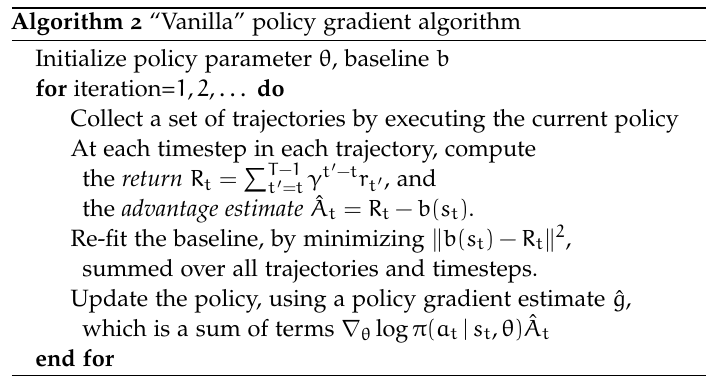

## Imports

In [ ]:
import gym
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.categorical import Categorical

## Rede Neural

In [ ]:
def logits_net(in_dim, out_dim):
    return nn.Sequential(nn.Linear(in_dim, 64),
                         nn.ReLU(),
                         nn.Linear(64, 64),
                         nn.ReLU(),
                         nn.Linear(64, out_dim))
    
def value_net(in_dim):
    return nn.Sequential(nn.Linear(in_dim, 32),
                         nn.ReLU(),
                         nn.Linear(32, 16),
                         nn.ReLU(),
                         nn.Linear(16, 1))

## Buffer PG

In [ ]:
class PGBuffer:
    def __init__(self, observation_space, max_length, gamma=1):
        self.gamma = gamma
        self.max_length = max_length
        self.states = np.zeros((max_length, *observation_space.shape), dtype=np.float32)
        self.actions = np.zeros(max_length, dtype=np.int32)
        self.rewards = np.zeros(max_length, dtype=np.float32)
        self.size = 0

    def update(self, state, action, reward):
        self.states[self.size] = state
        self.actions[self.size] = action
        self.rewards[self.size] = reward
        self.size += 1
        
    def clear(self):
        self.states[:] = 0
        self.actions[:] = 0
        self.rewards[:] = 0
        self.size = 0

    def get_returns(self):
        discounted_rewards = self.gamma**np.arange(self.max_length) * self.rewards
        return discounted_rewards[::-1].cumsum()[::-1].copy()

    def __len__(self):
        return self.size

## Agente PG

In [ ]:
class PGAgent:
    """
    Uma classe que cria um agente PG.
    """
    def __init__(self, 
                 observation_space, 
                 action_space,
                 max_length,
                 baseline=True,
                 gamma=0.99,
                 policy_lr=3e-4,
                 baseline_lr=3e-4):
        """
        Inicializa o agente com os parâmetros dados
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.gamma = gamma
        self.action_space = action_space
        self.memory = PGBuffer(observation_space, max_length, gamma=gamma)

        self.policy_logit = logits_net(observation_space.shape[0], action_space.n).to(self.device)
        self.policy_optimizer = optim.Adam(self.policy_logit.parameters(), lr=policy_lr)

        if baseline:
            self.baseline = value_net(observation_space.shape[0]).to(self.device)
            self.baseline_optimizer = optim.Adam(self.baseline.parameters(), lr=baseline_lr)
        else:
            self.baseline = None

    def policy(self, state):
        if not torch.is_tensor(state):
            state = torch.FloatTensor(state).to(self.device)
        p = Categorical(logits=self.policy_logit(state))
        return p

    def act(self, state):
        return self.policy(state).sample().item()

    def logp(self, state, action):
        action = torch.IntTensor(action).to(self.device)
        return self.policy(state).log_prob(action)

    def remember(self, state, action, reward):
        self.memory.update(state, action, reward)

    def is_full(self):
        return len(self.memory) == self.memory.max_length

    def train(self):
        size = len(self.memory)
        returns = self.memory.get_returns()[:size]
        states = torch.FloatTensor(self.memory.states[:size]).to(self.device)
        actions = self.memory.actions[:size]
        logps = self.logp(states, actions)

        advantages = torch.FloatTensor(returns).to(self.device)

        if self.baseline:
            v = self.baseline(states).flatten()
            advantages -= v.detach()
            baseline_loss = F.smooth_l1_loss(v, torch.FloatTensor(returns).to(self.device))
            self.baseline_optimizer.zero_grad()
            baseline_loss.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(self.baseline.parameters(), 1)
            self.baseline_optimizer.step()

        policy_loss = -(advantages * logps).sum()
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        self.memory.clear()

        return policy_loss.item(), (baseline_loss.item() if self.baseline else 0)

### Definição de parâmetros

In [ ]:
env_name = 'CartPole-v1'
env = gym.make(env_name)

In [ ]:
GAMMA = .999
MAX_LENGTH = 1000
POLICY_LR = 1e-3
BASELINE = True
BASELINE_LR = 4e-4

TRAIN_TIME = 100_000

### Criando o agente


In [ ]:
agent = PGAgent(env.observation_space, 
                env.action_space, 
                max_length=MAX_LENGTH,
                baseline=BASELINE,
                policy_lr=POLICY_LR,
                baseline_lr=BASELINE_LR,
                gamma=GAMMA)

## Treinamento

In [ ]:
def train(agent, env, total_timesteps):
    total_reward = 0
    episode_returns = []
    avg_returns = []

    state = env.reset()
    timestep = 0
    episode = 0
    pl = 0
    bl = 0

    while timestep < total_timesteps:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward)
        
        timestep += 1
        total_reward += reward

        if done:
            episode_returns.append(total_reward)
            avg_returns.append(np.mean(episode_returns[-10:]))
            episode += 1
            next_state = env.reset()
            pl, bl = agent.train()

        total_reward *= 1 - done
        state = next_state

        ratio = np.ceil(100 * timestep / total_timesteps)

        avg_return = avg_returns[-1] if avg_returns else np.nan
        
        print(f'\r[{ratio:3.0f}%] '
              f'timestep = {timestep}/{total_timesteps}, '
              f'episode = {episode:3d}, '
              f'avg_return = {avg_returns[-1] if avg_returns else 0 :10.4f}, '
              f'policy_loss={pl:9.4f}, '
              f'baseline_loss={bl:9.4f}', end='')
    print()

    if len(agent.memory) > 0:
        agent.train()
    return episode_returns, avg_returns

In [ ]:
returns, avg_returns = train(agent, env, TRAIN_TIME)

[100%] timestep = 100000/100000, episode = 530, avg_return =   427.6000, policy_loss=25033.2598, baseline_loss= 137.2648


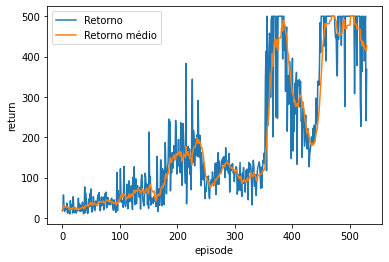

In [ ]:
plt.plot(returns, label='Retorno')
plt.plot(avg_returns, label='Retorno médio')
plt.xlabel('episode')
plt.ylabel('return')
plt.legend()
plt.show()

## Testando nosso Agente

In [ ]:
def evaluate(agent, env, episodes=10):
    total_reward = 0
    episode_returns = []
    
    episode = 0

    state = env.reset()

    while episode < episodes:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)        
       
        total_reward += reward

        if done:
            episode_returns.append(total_reward)
            episode += 1
            next_state = env.reset()

        total_reward *= 1 - done
        state = next_state

        ratio = np.ceil(100 * episode / episodes)
        
        print(f"\r[{ratio:3.0f}%] episode = {episode:3d}, avg_return = {np.mean(episode_returns) if episode_returns else 0:10.4f}", end="")

    return np.mean(episode_returns)

In [ ]:
evaluate(agent, env, 10)

[100%] episode =  10, avg_return =   486.9000

486.9

## Variância

In [ ]:
episodes = []
returns = []
avg_returns = []
for _ in range(5):
    agent_ = PGAgent(env.observation_space, 
                     env.action_space, 
                     max_length=MAX_LENGTH,
                     baseline=True,
                     policy_lr=POLICY_LR,
                     baseline_lr=BASELINE_LR,
                     gamma=GAMMA)
    x, y = train(agent_, env, TRAIN_TIME)
    returns += x
    avg_returns += y
    episodes += list(range(len(x))) 

[100%] timestep = 100000/100000, episode = 592, avg_return =   276.5000, policy_loss=17362.7930, baseline_loss= 111.8205
[100%] timestep = 100000/100000, episode = 566, avg_return =   468.2000, policy_loss=49691.1836, baseline_loss= 177.0182
[100%] timestep = 100000/100000, episode = 461, avg_return =   426.4000, policy_loss=47646.2656, baseline_loss= 174.7154
[100%] timestep = 100000/100000, episode = 648, avg_return =   240.2000, policy_loss=16277.6621, baseline_loss= 109.2883
[100%] timestep = 100000/100000, episode = 412, avg_return =   451.0000, policy_loss=39174.3555, baseline_loss= 172.4537


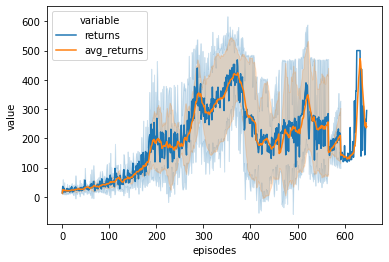

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame({'episodes': episodes, 'returns': returns, 'avg_returns': avg_returns})
melted = df.melt(id_vars=['episodes'], value_vars=['returns', 'avg_returns'])
sns.lineplot(x='episodes', y='value', hue='variable', data=melted, ci='sd')

In [ ]:
episodes = []
returns = []
avg_returns = []
for _ in range(5):
    agent_ = PGAgent(env.observation_space, 
                     env.action_space, 
                     max_length=MAX_LENGTH,
                     baseline=False,
                     policy_lr=POLICY_LR,
                     baseline_lr=BASELINE_LR,
                     gamma=GAMMA)
    x, y = train(agent_, env, TRAIN_TIME)
    returns += x
    avg_returns += y
    episodes += list(range(len(x))) 

[100%] timestep = 100000/100000, episode = 457, avg_return =   418.3000, policy_loss=50360.8008, baseline_loss=   0.0000
[100%] timestep = 100000/100000, episode = 607, avg_return =   175.8000, policy_loss=7249.4976, baseline_loss=   0.0000
[100%] timestep = 100000/100000, episode = 708, avg_return =   136.1000, policy_loss=3325.9888, baseline_loss=   0.0000
[100%] timestep = 100000/100000, episode = 385, avg_return =   484.9000, policy_loss=48368.5547, baseline_loss=   0.0000
[100%] timestep = 100000/100000, episode = 452, avg_return =   475.9000, policy_loss=44360.0664, baseline_loss=   0.0000


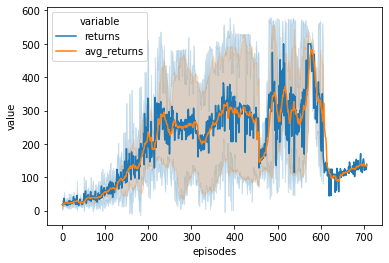

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame({'episodes': episodes, 'returns': returns, 'avg_returns': avg_returns})
melted = df.melt(id_vars=['episodes'], value_vars=['returns', 'avg_returns'])
sns.lineplot(x='episodes', y='value', hue='variable', data=melted, ci='sd')